In [1]:
import scqubits as scqubits

import jax.numpy as jnp
from jax.scipy.optimize import minimize
import jax.scipy as sci
import qutip as qt
import matplotlib.pyplot as plt
import os
import dynamiqs as dq
from swt import swt_subspace
# Set JAX NumPy precision to float64
import jax
try:
    from jax.config import config
except ImportError:
    # Fallback for older JAX versions
    config = jax.config
config.update("jax_enable_x64", True)

# Disable JAX multi-threading to avoid issues with fork
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Disable GPU if present
# Set thread count to 1 to disable parallelism
config.update('jax_platforms', 'cpu')  # Force CPU backend
config.update('jax_disable_jit', True)  # Disable JIT compilation




class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence = True, twolevelapp = False):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*jnp.pi
        self.Ec = Ec * 2*jnp.pi
        self.beta = 1
        self.N = 1
        self.original_dim = bare_dim
        self.trunc_dim = trunc_dim
        self.sdim, self.c2dim, self.c1dim = bare_dim
        self.total_dim = self.sdim*self.c2dim*self.c1dim
        self.omega_c1 = omega_c1
        self.omega_c2 = omega_c2
        self.phizpf_dependence = phizpf_dependence
        self.twolevelapp = twolevelapp
        self.g = 0.05*2*jnp.pi
        self.option = dq.Options(progress_meter=None)
        self.H , self.H_control = self.get_H()
        self.H_dressed, self.H_control_dressed = self.dressed_basis()
        

    def sort_eigenpairs(self, eigenvalues, eigenvectors):
        n = eigenvectors.shape[0]
        sorted_indices = []

        for i in range(n):
            max_abs_vals = jnp.abs(eigenvectors[i, :])
            max_index = jnp.argmax(max_abs_vals)
            while max_index in sorted_indices:
                max_abs_vals = max_abs_vals.at[max_index].set(-jnp.inf)
                max_index = jnp.argmax(max_abs_vals)
            sorted_indices.append(max_index)

        sorted_indices_array = jnp.array(sorted_indices)
        sorted_eigenvalues = eigenvalues[sorted_indices_array]
        sorted_eigenvectors = eigenvectors[:, sorted_indices_array]
        return sorted_eigenvalues, sorted_eigenvectors
    
    def state_index(self, index,dim):
        n,k,m = index
        N,K,M = dim
        return n*K*M + k*M + m
    
    def get_indices(self, trunc):
        """
        Convert a list of 3D indices to 1D indices based on given dimensions.
        indecies follow (squid, cavity2, cavity1)
        
        Args:
            trunc: List of three integers [N,K,M] specifying the dimensions to include
                 N is number of SNAIL states
                 K is number of cavity 2 states
                 M is number of cavity 1 states
                 
        Returns:
            List of 1D indices corresponding to the 3D indices
        """
        N, K, M = trunc
        indices_1d = []
        
        # Generate all 3D indices and store indices outside truncation
        for n in range(self.sdim):
            for k in range(self.c2dim):
                for m in range(self.c1dim):
                    # Only add indices that are outside the truncation
                    if n >= N or k >= K or m >= M:
                        index = [n,k,m]
                    
                        # Convert to 1D index using state_index method
                        idx = self.state_index(index, self.original_dim)
                        indices_1d.append(idx)
        return indices_1d
        
    def remove_row_col(self, matrix, indices):
        # Check if matrix is square
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square")
        
        # Convert single index to list if needed
        if isinstance(indices, (int, jnp.integer)):
            indices = [indices]
            
        # Convert to list if numpy array
        if isinstance(indices, jnp.ndarray):
            indices = indices.tolist()
            
        # Sort indices in descending order to avoid changing indices when deleting
        indices = sorted(indices, reverse=True)
        
        # Check if indices are valid
        if any(i < 0 or i >= matrix.shape[0] for i in indices):
            raise ValueError(f"All indices must be between 0 and {matrix.shape[0]-1}")
        
        # Remove rows and columns
        result = matrix.copy()
        for idx in indices:
            result = jnp.delete(jnp.delete(result, idx, axis=0), idx, axis=1)
            
        return result
    
    def truncate_matrix(self, matrix, trunc):
        indices = self.get_indices(trunc)
        return self.remove_row_col(matrix, indices)
    
    def annihilation(self, dim):
        return jnp.diag(jnp.sqrt(jnp.arange(1,dim)),1)
    def creation(self, dim):
        return jnp.diag(jnp.sqrt(jnp.arange(1,dim)),-1)
    def tensor_product(self,A,B,C):
        return jnp.kron(A,jnp.kron(B,C))

    def cosm(self, matrix):
        return (sci.linalg.expm(1j*matrix) + sci.linalg.expm(-1j*matrix))/2
    
    def SNAIL(self):
        """
        This function starts from SNAIL hamiltonian in oscillator basis,  and then calculates the SNAIL Hamiltonian and returns the Hamiltonian and the charge operator in eigenbasis. 
        returns: Hs, charge_op in eigenbasis
        """
        beta = self.beta
        N = self.N
        Ej = self.Ej
        Ec = self.Ec
        phi_ex = self.phi_ex*2*jnp.pi
        sdim = 40
        # Find minimum of SNAIL potential
        def U_s(phi): 
            # Need to ensure the function returns a scalar for JAX gradient
            return jnp.asarray(-beta*jnp.cos(phi-phi_ex)-N*jnp.cos(phi/N))[0]
        
        phi_min = minimize(U_s, jnp.array([0.]), method='BFGS').x
        # potential expansion around minimum
        c2 = beta*jnp.cos(phi_min - phi_ex) + 1/N*jnp.cos(phi_min/N)
        omega_s = jnp.sqrt(8*c2*Ej*Ec)
        if self.phizpf_dependence == True:
            phi_zpf = jnp.power(2*Ec/(Ej*c2),1/4)
        else:
            phi_zpf = jax.lax.stop_gradient(jnp.power(2*Ec/(Ej*c2),1/4))
        self.phi_zpf = phi_zpf
        g2 = Ej*phi_zpf**2*c2/2
        s = self.annihilation(sdim)
        sd = self.creation(sdim)
        x2 = jnp.matmul(s+sd,s+sd)
        Hs =( omega_s * jnp.matmul(sd,s)
            - Ej*(beta*self.cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*jnp.identity(sdim))
            + N*self.cosm((phi_zpf*(s+sd)+phi_min*jnp.identity(sdim))/N))- g2*x2)
        charge_op = -1j*(s-sd)/2/phi_zpf
        energy0,U = jnp.linalg.eigh(Hs)
        energy0,U = self.sort_eigenpairs(energy0, U)
        energy0 = energy0 - energy0[0]
        Ud = U.transpose().conjugate()
        Hs = Ud@Hs@U
        charge_op = Ud@charge_op@U
        Hs = Hs - Hs[0,0]*jnp.identity(sdim)
        Hs = Hs[0:self.sdim,0:self.sdim]
        charge_op = charge_op[0:self.sdim,0:self.sdim]
        return Hs,charge_op
    
    def get_H(self):
        """This function calculates the composite system Hamiltonian and returns the Hamiltonian and the SNAIL charge operator in composite Hilbert space. Returned matrix is under eigenbasis of each subsystem
        returns: H = Hc1 + Hc2 + Hs + H_int1 + H_int2, charge_op in composite Hilbert space
        """
        c1dim = 20
        c2dim = 20

        Hs,charge_op, = self.SNAIL()
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=self.omega_c1,
            truncated_dim = c1dim
        )
        Hc = jnp.diag(jnp.array(cavity.eigenvals(evals_count=c1dim) - cavity.eigenvals(evals_count=c1dim)[0]))*2*jnp.pi
        Hc = Hc[0:self.c1dim,0:self.c1dim]
        Vc = jnp.array(cavity.creation_operator() + cavity.annihilation_operator())
        Vc = Vc[0:self.c1dim,0:self.c1dim]
        cavity = [Hc,Vc]

        cavity2 = scqubits.Oscillator(
            E_osc=self.omega_c2,
            truncated_dim = c2dim
        )
        Hc2 = jnp.diag(jnp.array(cavity2.eigenvals(evals_count=c2dim) - cavity2.eigenvals(evals_count=c2dim)[0]))*2*jnp.pi
        Hc2 = Hc2[0:self.c2dim,0:self.c2dim]
        Vc2 = jnp.array(cavity2.creation_operator() + cavity2.annihilation_operator())
        Vc2 = Vc2[0:self.c2dim,0:self.c2dim]
        cavity2 = [Hc2,Vc2]
        H,H_control = self.composite_sys(squid,cavity,cavity2)
        return H,H_control

    def composite_sys(self, squid,cavity, cavity2,):
        Hs, charge_op = squid
        Hc, Vc = cavity
        Hc2, Vc2 = cavity2
        sdim = Hs.shape[0]
        cdim = Hc.shape[0]
        cdim2 = Hc2.shape[0]
        Ic = jnp.identity(cdim)
        Ic2 = jnp.identity(cdim2)
        Is = jnp.identity(sdim)
        Hs = self.tensor_product(Hs,Ic,Ic2)
        Hc = self.tensor_product(Is, Hc, Ic2)
        Hc2 = self.tensor_product(Is, Ic, Hc2)
        H_int = self.g * self.tensor_product(charge_op, Vc, Ic2) 
        H_int2 = self.g * self.tensor_product(charge_op, Ic, Vc2) 
        H = Hs + Hc + Hc2 + H_int + H_int2
        H_control = self.tensor_product(charge_op, Ic, Ic2)
        return H, H_control

    def dressed_basis(self):
        H , H_control = self.get_H()
        evals,U = jnp.linalg.eigh(H)
        evals,U = self.sort_eigenpairs(evals,U)
        Ud = U.transpose().conjugate()
        H_dressed = Ud@H@U
        H_dressed = H_dressed - H_dressed[0,0]*jnp.identity(self.total_dim)
        H_control_dressed = Ud@H_control@U
        return H_dressed, H_control_dressed
    
    def omegasder(self, ):
        Hs, _ = self.SNAIL()
        """
        Calculate the energy of the first excited state (omegas) and its derivative with respect to phi_ex
        
        Returns:
            Tuple containing (omegas, derivative of omegas)
        """
        # Get the energy of the first excited state
        omegas = Hs[1, 1]
        
        # Define a function that computes the first excited state energy for a given phi
        def energy_level(phi):
            sc = Hamiltonian(phi, self.Ej/(2*jnp.pi), self.Ec/(2*jnp.pi), 
                           self.original_dim, self.trunc_dim, self.omega_c1, 
                           self.omega_c2, self.phizpf_dependence, self.twolevelapp)
            H, _ = sc.SNAIL()
            return jnp.real(H[1, 1])  # Return the energy of the first excited state
        
        # Compute derivative of omegas with respect to phi_ex
        derivative = jax.grad(energy_level)(self.phi_ex)
        
        return omegas, derivative

    def der_formula(self, A, omegad):
        Hs, _ = self.SNAIL()
        _, omegasder = self.omegasder()
        omegas = Hs[1,1]
        anh = Hs[2,2] - 2*Hs[1,1]
        g = self.g/2/self.phi_zpf
        A = A/2/self.phi_zpf
        Delta = omegas - self.omega_c1*2*jnp.pi
        omegas += g**2/Delta
        delta = omegas - omegad
        der = g**2/Delta**2*(1 - A**2/delta**3/2*anh)
        return der*omegasder
    
    def keep_same_elements(self, target, given):
        """
        Modifies the given matrix to have non-zero elements only where the target matrix has non-zero elements.
        
        Args:
            target: The reference matrix that defines the non-zero pattern
            given: The matrix to be modified
            
        Returns:
            A modified version of the given matrix with zeros where target has zeros
        """
        # Create a mask where target is non-zero
        mask = jnp.abs(target) > 1e-10
        # Apply the mask to the given matrix
        return jnp.where(mask, given, 0.0)
    

    def HR(self, A, omegad):
        H0, Hc = self.H_dressed, self.H_control_dressed
        s = self.annihilation(self.sdim)
        sd = self.creation(self.sdim)
        Ic1 = jnp.identity(self.c1dim)
        Ic2 = jnp.identity(self.c2dim)
        H0 = H0 - self.tensor_product(omegad*sd@s, Ic1, Ic2)
        target = self.tensor_product(sd+s, Ic1, Ic2)
        Hc = self.keep_same_elements(target, Hc)
        if self.twolevelapp == True:
            H0 = self.truncate_matrix(H0, [2, self.trunc_dim[1], self.trunc_dim[2]])
            Hc = self.truncate_matrix(Hc, [2, self.trunc_dim[1], self.trunc_dim[2]])
        else:
            H0 = self.truncate_matrix(H0, self.trunc_dim)
            Hc = self.truncate_matrix(Hc, self.trunc_dim)
        self.H_dressed_truncated = H0
        self.Hcapp = Hc
        H = H0 + A/2*Hc
        eigvals, _ = jnp.linalg.eigh(H)
        eigvals, _ = self.sort_eigenpairs(eigvals, _)
        eigvals = eigvals - eigvals[0]
        # Return the first few energy levels based on truncation dimensions
        if self.trunc_dim[1] == 1:
            return eigvals[1], eigvals[2], eigvals[3]
        else:
            return eigvals[1], eigvals[self.trunc_dim[2]]
    
    def approximateder(self, A=0.0, omegad=0.0):
        """
        Calculate the derivative of the rotating frame Hamiltonian energies with respect to phi_ex
        
        Args:
            A: Drive amplitude
            omegad: Drive frequency
            
        Returns:
            Array of derivatives for each energy level
        """
        # Define a function that computes energy levels for a given phi
        def energy_levels(phi):
            sc = Hamiltonian(phi, self.Ej/(2*jnp.pi), self.Ec/(2*jnp.pi), 
                            self.original_dim, self.trunc_dim, self.omega_c1, 
                            self.omega_c2, self.phizpf_dependence, self.twolevelapp)
            return sc.HR(A, omegad)
        
        # Compute derivatives and flatten the result
        return jax.jacobian(energy_levels)(self.phi_ex)
    
    def floquet_eigenvectors(self, A=0e-3*2*jnp.pi, omega=6.185*2*jnp.pi):
        """
        Calculate the Floquet eigenvectors for the system.
        
        Args:
            A: Drive amplitude
            omega: Drive frequency
            
        Returns:
            Eigenvectors of the Floquet propagator
        """
        H0, Hc = self.H_dressed, self.H_control_dressed
        H0 = dq.asqarray(H0)
        Hc = dq.asqarray(Hc)
        T = (2 * jnp.pi) / omega
        tsave = jnp.linspace(0, T, 10)
        # Define the Hamiltonian
        def cos_drive(t):
            return A * jnp.cos(omega * t)
        H = H0 + dq.modulated(cos_drive, Hc)
        result = dq.sepropagator(H, tsave, options=self.option)
        U = result.final_propagator
        # Only compute and return eigenvectors
        evecs = U._eig()[1]
        return evecs
    
    def quasi_energy(self, evecs, A=0e-3*2*jnp.pi, omega=6.185*2*jnp.pi):
        """
        Calculate the quasi-energies of the system.
        
        Args:
            evecs: Eigenvectors from floquet_eigenvectors
            A: Drive amplitude
            omega: Drive frequency
            
        Returns:
            Quasi-energies of the system
        """
        # Rebuild the propagator to get eigenvalues only
        H0, Hc = self.H_dressed, self.H_control_dressed
        H0 = dq.asqarray(H0)
        Hc = dq.asqarray(Hc)
        T = (2 * jnp.pi) / omega
        tsave = jnp.linspace(0, T, 10)
        def cos_drive(t):
            return A * jnp.cos(omega * t)
        H = H0 + dq.modulated(cos_drive, Hc)
        result = dq.sepropagator(H, tsave, options=self.option)
        U = result.final_propagator
        evals = U._eigvals()
        evals, evecs = self.sort_eigenpairs(evals, evecs.to_jax())
        e_quasi = -jnp.angle(evals)/T
        e_quasi = e_quasi - e_quasi[0] * jnp.ones(len(e_quasi))
        if self.trunc_dim[1] == 1:
            return e_quasi[1], e_quasi[2], e_quasi[3]
        else:
            return e_quasi[1], e_quasi[self.trunc_dim[2]]
    
    def equasi_gradient(self, A, omega):
        """
        Compute the gradient of quasi-energy with respect to phi_ex
        
        Args:
            A: Drive amplitude
            omega: Drive frequency
            
        Returns:
            Gradient of quasi-energy with respect to phi_ex
        """
        # Compute eigenvectors once and detach them from the computational graph
        evecs = jax.lax.stop_gradient(self.floquet_eigenvectors(A, omega))
        
        def quasi_energy_levels(phi):
            sc = Hamiltonian(phi, self.Ej/(2*jnp.pi), self.Ec/(2*jnp.pi), 
                               self.original_dim, self.trunc_dim, self.omega_c1, 
                               self.omega_c2, self.phizpf_dependence, self.twolevelapp)
            
            # Use the detached eigenvectors to compute quasi-energy
            return sc.quasi_energy(evecs, A, omega)
        
        # Compute the Jacobian with respect to phi_ex and flatten the result
        return jax.jacobian(quasi_energy_levels)(self.phi_ex)
    
    def analytical_app(self, A, omegad):
        """
        Compute the derivative of the Schrieffer-Wolff transformed energies with respect to phi_ex.

        Args:
            A: Drive amplitude
            omegad: Drive frequency

        Returns:
            Array of derivatives for each energy level.
        """
        def transformation(phi):
            sc = Hamiltonian(phi, self.Ej/(2*jnp.pi), self.Ec/(2*jnp.pi),
                               self.original_dim, self.trunc_dim, self.omega_c1,
                               self.omega_c2, self.phizpf_dependence, self.twolevelapp)
            sc.HR(A, omegad)
            H0 = sc.H_dressed_truncated
            V = sc.Hcapp
            return swt_subspace(H0, A / 2 * V)

        return jax.jacobian(transformation)(self.phi_ex)

    def static_rate(self, der):
        A = 5e-6
        return jnp.abs(der*4.4)*1e6*A

In [7]:
#check approximations

Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10,1,6]
trunc_dim = [5,1,4]
# Define the combinations of parameters to test
combinations = [
    (True, True),
    (True, False),
    (False, True),
    (False, False)
]

A = 10e-3*2*jnp.pi
omega_ds = jnp.linspace(6.15, 6.23, 20)*2*jnp.pi
all_static_rates = []
labels = []

# Calculate static rates for each combination of parameters
for phizpf_dependence, twolevelapp in combinations:
    sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence, twolevelapp)
    
    # Calculate static rates for each drive frequency in omega_ds
    static_rates = []
    for omegad in omega_ds:
        # Get the derivative for the second level (index 1) and calculate the static rate
        der = sc.approximateder(A, omegad)[1]
        rate = sc.static_rate(der)
        static_rates.append(rate)
    
    # Convert to numpy array for plotting
    static_rates = jnp.array(static_rates)
    all_static_rates.append(static_rates)
    
    # Create label for the legend
    label = f"phizpf={phizpf_dependence}, twolevel={twolevelapp}"
    labels.append(label)
    



KeyboardInterrupt: 

In [11]:
Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10,1,6]
trunc_dim = [5,1,4]

A = 10e-3*2*jnp.pi
omega_ds = jnp.linspace(6.15, 6.23, 20)*2*jnp.pi
# Also compute using der_formula
formula_rates = []
exact_rates = []
sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence=True, twolevelapp=True)
for omegad in omega_ds:
    der = sc.der_formula(A, omegad)
    rate = sc.static_rate(der)
    formula_rates.append(rate)
    exact_rates.append(sc.static_rate(sc.equasi_gradient(A, omegad)[0]))

formula_rates = jnp.array(formula_rates)
all_static_rates.append(formula_rates)


KeyboardInterrupt: 

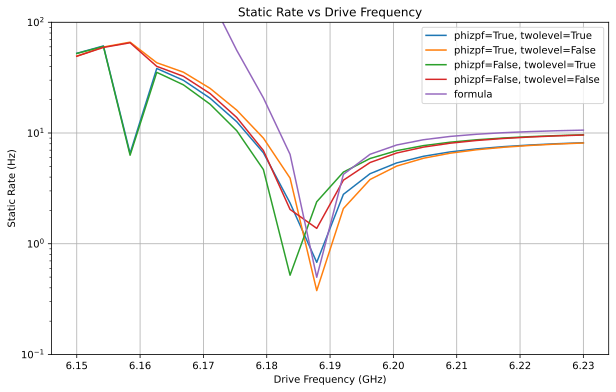

In [4]:
# Plot the static rate vs drive frequency for all combinations
plt.figure(figsize=(10, 6))
for i, static_rates in enumerate(all_static_rates):
    plt.plot(omega_ds/2/jnp.pi, static_rates, label=labels[i])
plt.xlabel('Drive Frequency (GHz)')
plt.ylabel('Static Rate (Hz)')
plt.title('Static Rate vs Drive Frequency')
plt.legend()
plt.yscale('log')
plt.ylim(1e-1, 100)
plt.grid(True)
plt.show()

In [34]:
Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10,1,6]
trunc_dim = [5,1,4]

# Define different amplitudes
amplitudes = [5e-3*2*jnp.pi, 3e-4*2*jnp.pi]
omega_ds = jnp.linspace(6.15, 6.18, 30)*2*jnp.pi
sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence=True, twolevelapp=False)
rates = []
for A in amplitudes:
    A_rates = []
    for omegad in omega_ds:
        der = sc.approximateder(A, omegad)[1:4]
        der = der.at[2].set(der[2] - der[1])
        der = der.at[1].set(der[1] - der[0])
        A_rates.append(sc.static_rate(der))
    rates.append(A_rates)
rates = jnp.array(rates)  # Shape will be (3, 20, 3)

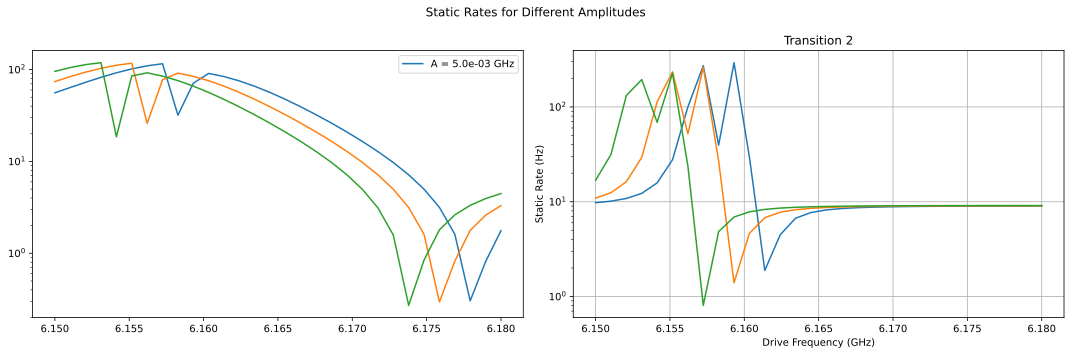

In [35]:
# Create a figure with 3 subplots (one for each transition)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Static Rates for Different Amplitudes')

# Plot each transition in a separate subplot
for i in range(3):  # For each transition
    for j, A in enumerate(amplitudes):  # For each amplitude
        label = f'A = {A/(2*jnp.pi):.1e} GHz'
        # rates shape is (2, 30, 3): [amplitude, frequency, transition]
        axs[j].plot(omega_ds/(2*jnp.pi), rates[j, :, i], label=label if i == 0 else None)
        axs[j].set_yscale('log')
    axs[j].set_xlabel('Drive Frequency (GHz)')
    axs[j].set_ylabel('Static Rate (Hz)')
    axs[j].set_title(f'Transition {i}')
    
    axs[j].grid(True)

# Only add legend to the first subplot
axs[0].legend()
plt.tight_layout()
plt.show()

In [6]:
Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10,1,6]
trunc_dim = [5,1,4]
sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2, phizpf_dependence=True, twolevelapp=False)
# Get the first element of approximateder at a specific point
specific_der = sc.approximateder(1e-3*2*jnp.pi, 6.185*2*jnp.pi)[0]
print(specific_der)

# Define different amplitudes and frequencies for 2D scan
d = 20
omega_ds_2d = jnp.linspace(6.17, 6.19, d)*2*jnp.pi  # Drive frequencies in GHz
As_2d = 2*jnp.pi*jnp.linspace(1e-3, 10e-3, d)  # Drive amplitudes from 1 to 10 mA

# Create meshgrid for 2D plot
omega_mesh, A_mesh = jnp.meshgrid(omega_ds_2d, As_2d)
rates_2d = jnp.zeros((d, d))
rates_2d_ = jnp.zeros((d, d))

# Double for loop to compute derivatives at each point
for i, A in enumerate(As_2d):
    for j, omegad in enumerate(omega_ds_2d):
        der = sc.der_formula(A, omegad)
        approx_der = sc.approximateder(A, omegad)[0]
        # Assuming we want to plot the first transition rate
        rates_2d = rates_2d.at[i, j].set(der[0])
        rates_2d_ = rates_2d_.at[i, j].set(approx_der)

# Create 2D plots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot der_formula results
im1 = axs[0].pcolormesh(omega_mesh/(2*jnp.pi), A_mesh/(2*jnp.pi), rates_2d, shading='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[0], label='Derivative (der_formula)')
axs[0].set_xlabel('Drive Frequency (GHz)')
axs[0].set_ylabel('Drive Amplitude (GHz)')
axs[0].set_title('der_formula: Derivative as a function of drive frequency and amplitude')

# Plot approximateder results
im2 = axs[1].pcolormesh(omega_mesh/(2*jnp.pi), A_mesh/(2*jnp.pi), rates_2d_, shading='auto', cmap='viridis')
fig.colorbar(im2, ax=axs[1], label='Derivative (approximateder)')
axs[1].set_xlabel('Drive Frequency (GHz)')
axs[1].set_ylabel('Drive Amplitude (GHz)')
axs[1].set_title('approximateder: Derivative as a function of drive frequency and amplitude')

plt.tight_layout()
plt.show()


Array([-0.50655546+0.j], dtype=complex128)